# MST and Shortest path problems

##### *Команда 9:*
* *Басистий Олег*
* *Кравчук Андрій*
##### *Задачі:*
* дослідити та імплементувати найпоширеніші алгоритми на знаходження найкортшого шляху;
* порівняти з версіями з різних пайтонівських бібліотек (NetworkX);
* дослідити, чому певні алгоритми працюють краще, або гірше;

## Prerequisites

In [1]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm

In [4]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import time
from itertools import combinations, groupby
from tqdm import tqdm

In [5]:
VALS=[5,10,20,50,100,200,500]

## Генерація графу
Для зручності використання, ми вирішили розділити початку функцію на дві.

In [6]:

def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
    return G

def draw(graph: nx.Graph | nx.DiGraph):
    """
    Draws the given graphh
    """
    plt.figure(figsize=(10,6))
    pos = nx.arf_layout(graph)
    nx.draw(graph,pos, node_color='lightblue',
            with_labels=True,
            node_size=500,
            arrowsize=20,
            arrows=True)
    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph, pos,edge_labels=labels)
    plt.show()


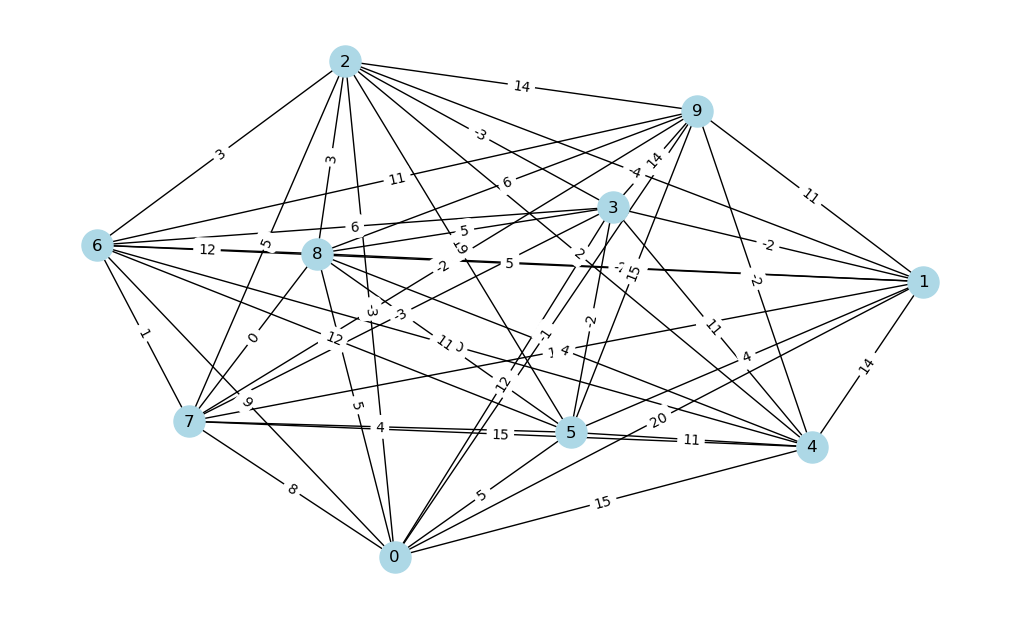

In [5]:
G = gnp_random_connected_graph(10, 1, False)
draw(G)

## Tester class
Tester - клас, створений для порівняння функцій, імплементованих нами та готових варіантів.  
Метод time_test - порівнює функції та додає в список з часом - час, за який виконалась функція.  
Метод draw_graph - малює порівняльні графіки двох функцій.  
Метод test_multiple - тест часу + побудова графіка для будь-якої кількості функцій.

In [2]:
class Tester():
    """
    Time test and graph drawer class
    """
    def __init__(self, function: callable, function_nx: callable, algorithm: str) -> None:
        self.function=function
        self.function_nx=function_nx
        self.algorithm=algorithm
        self.own_time_list=[0]
        self.value_list=[0]
        self.algo_time_list=[0]

    def time_test(self, ITERATIONS, values = [],is_dir=False) -> None:
        """
        Finds how much time the function executes
        """
        for value in tqdm(values):
            tmp_time=0
            tmp_time_2=0
            for _ in range(ITERATIONS):
                tmp_graph=gnp_random_connected_graph(value, 100, is_dir)
                start_time=time.time()
                self.function(tmp_graph)
                tmp_time+=(time.time()-start_time)

                start_time=time.time()
                self.function_nx(tmp_graph,algorithm=self.algorithm) if self.algorithm else self.function_nx(tmp_graph)
                tmp_time_2+=(time.time()-start_time)
            
            self.value_list.append(value)
            self.own_time_list.append(tmp_time/ITERATIONS)
            self.algo_time_list.append(tmp_time_2/ITERATIONS)
            print(f'OWN IMPLEMENTATION\nmean time == {self.own_time_list[-1]} N={value}\n\n\
nx implementation\nmean time == {self.algo_time_list[-1]} N={value}')

    def draw_graph(self):
        """
        Draws time graph
        """
        ax=plt.subplot()
        line1=ax.plot(self.value_list,self.own_time_list,label=self.function.__name__+", own implementation")
        ax.set_ylabel('Runtime')
        ax.set_xlabel('Values')
        line2=ax.plot(self.value_list,self.algo_time_list,label=self.function.__name__+", nx implementation")
        ax.legend()
        plt.show()
    
    @staticmethod
    def test_multiple(functions,VALS,ITERATIONS,is_dir=False):
        time_list=[[0] for _ in range(len(functions))]
        for value in tqdm(VALS):
            tmp_time=[0 for _ in range(len(functions))]
            for _ in range(ITERATIONS):
                tmp_graph=gnp_random_connected_graph(value, 100, is_dir)
                for func in functions:
                    start=time.time()
                    func(tmp_graph)
                    tmp_time[functions.index(func)]+=time.time()-start
            for i, val in enumerate(tmp_time):
                time_list[i].append(val/ITERATIONS)
                
        lines=[]
        VALS=[0]+VALS
        plt.xlabel('Values')
        plt.ylabel('Runtime')
        print(time_list[0])
        print(VALS)
        for i in range(len(functions)):
            plt.plot(VALS,time_list[i],label=functions[i].__name__)
        plt.legend()
        plt.show()

# For Task 1

## Kruskal's algorithm

#### NetworkX Implementation

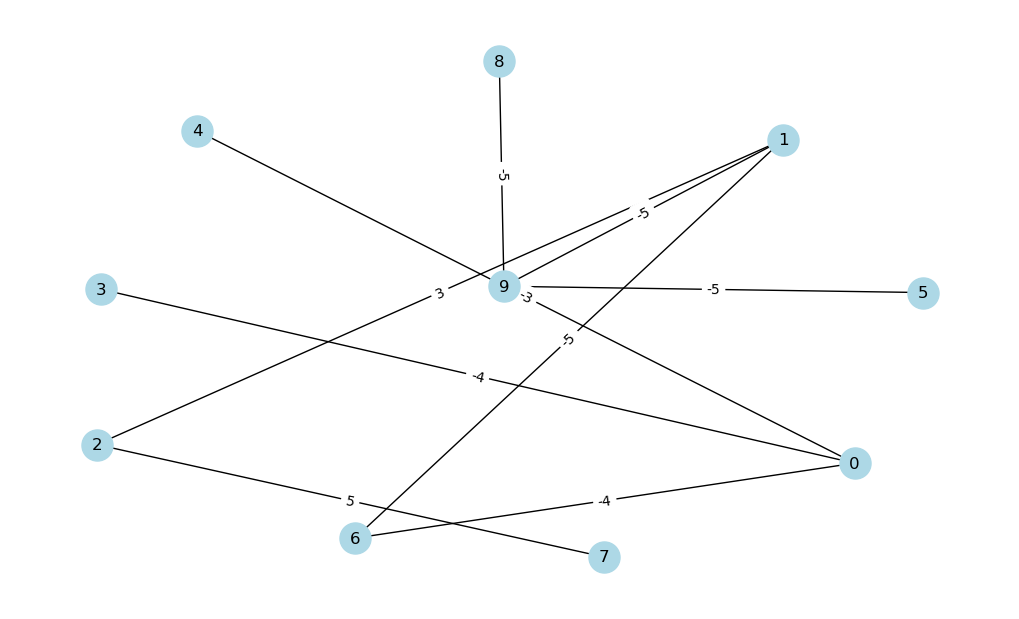

In [7]:
from networkx.algorithms.tree import minimum_spanning_tree
mstk = minimum_spanning_tree(G, algorithm="kruskal")
draw(mstk)

In [8]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 3), (0, 6), (0, 4), (1, 6), (1, 9), (1, 2), (2, 7), (5, 9), (8, 9)]),
 9)

In [9]:
def kruskall_wrap(gr):
    return minimum_spanning_tree(gr, algorithm="kruskal")

#### Own Implementation

In [10]:
class DisjointSet:
    """
    Disjoin set class;
    """
    def __init__(self, graph: nx.Graph)-> None:
        self.parents={node: node for node in graph.nodes}
    def find(self, u):
        """
        Recursively finds node's parent
        """
        if self.parents[u]==u:
            return u
        return self.find(self.parents[u])
    def union(self, u, v):
        """
        Unites 2 different nodes
        """
        if self.find(u)!=self.find(v):
            self.parents[self.find(u)]=v

def kruskal(graph: nx.Graph)-> nx.Graph | None:
    """
    Finds a MST for the graph using Kruskal's algorithm.
    Returns none if graph is disconnected
    """
    if not nx.is_connected(graph):
        return None
    graph_set=DisjointSet(graph)
    result_graph=nx.Graph()
    edges=sorted([(u,v,w['weight']) for u,v,w in graph.edges(data=True)],key=lambda x:x[2])
    while len(result_graph.edges)<len(graph.nodes)-1:
        curr_edge=edges.pop(0)
        if graph_set.find(curr_edge[0])!=graph_set.find(curr_edge[1]):
            result_graph.add_edge(curr_edge[0],curr_edge[1],weight=curr_edge[2])
            graph_set.union(curr_edge[0],curr_edge[1])
    return result_graph

Алгоритм Краскалла використовує Disjoint-set *(Union-find ds/ merge-find set)* - структура даних, яка зберігає розділи множини в нез'єднаних підмножинах, та надає доступ для зручного знаходження вершини та їх об'єднання. Ця структура даних відіграє найважливішу роль у цьому алгоритмі.    
Концепт  Алгоритму Краскала полягає в тому, щоб з посортованого списку ребер з мінімальними вагами, вилучати по ребру (без утворення простих циклів), допоки ми зрештою не сполучим усі вершини.

#### Comparison

In [11]:
kruskal_test=Tester(kruskal,minimum_spanning_tree,"kruskal")
kruskal_test.time_test(10,VALS)

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 32.79it/s]

OWN IMPLEMENTATION
mean time == 6.392002105712891e-05 N=5

nx implementation
mean time == 5.5789947509765625e-05 N=5
OWN IMPLEMENTATION
mean time == 6.833076477050782e-05 N=10

nx implementation
mean time == 8.747577667236328e-05 N=10
OWN IMPLEMENTATION
mean time == 0.00018994808197021485 N=20

nx implementation
mean time == 0.00027751922607421875 N=20
OWN IMPLEMENTATION
mean time == 0.0011647701263427734 N=50

nx implementation
mean time == 0.0016291618347167968 N=50
OWN IMPLEMENTATION
mean time == 0.004662656784057617 N=100

nx implementation
mean time == 0.006428265571594238 N=100
OWN IMPLEMENTATION
mean time == 0.03521444797515869 N=200

nx implementation
mean time == 0.08667962551116944 N=200


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

OWN IMPLEMENTATION
mean time == 0.3066877841949463 N=500

nx implementation
mean time == 0.2893527984619141 N=500


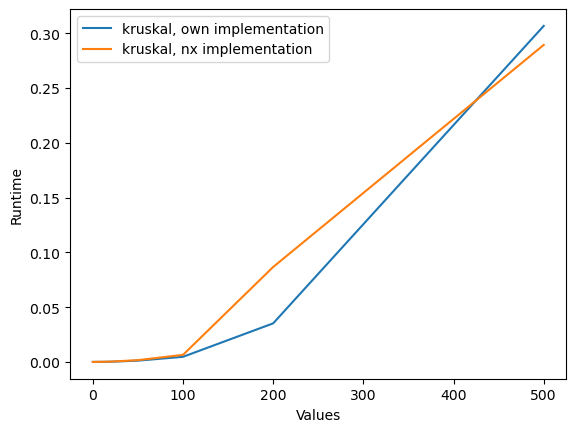

[0,
 5.5789947509765625e-05,
 8.747577667236328e-05,
 0.00027751922607421875,
 0.0016291618347167968,
 0.006428265571594238,
 0.08667962551116944,
 0.2893527984619141]

In [12]:
kruskal_test.draw_graph()
kruskal_test.algo_time_list

#### Kruskall's conlusion
Як можемо побачити за графіками, наша версія алгоритму Краскалла навіть трохи й виграє версію NetworkX. Все це - через структуру даних, яку використовує алгоритм Краскалла.  
Програма найкраще працюватиме у таких графах, де перші n-1 ребер є в мінімальному каркасі. В такому випадку, нам вдастьтся уникнути лишніх обчислень.  
Так як нам вдалося обраховувати все швидше, ніж це робить версія NetworkX - нам дуже навіть успішно вдалося реалізувати цей алгоритм.

## Prim's algorithm

#### NetworkX Implementation

In [13]:
mstp = minimum_spanning_tree(G, algorithm="prim")

In [14]:
def prim_wrap(gr):
    return minimum_spanning_tree(gr, algorithm="prim")

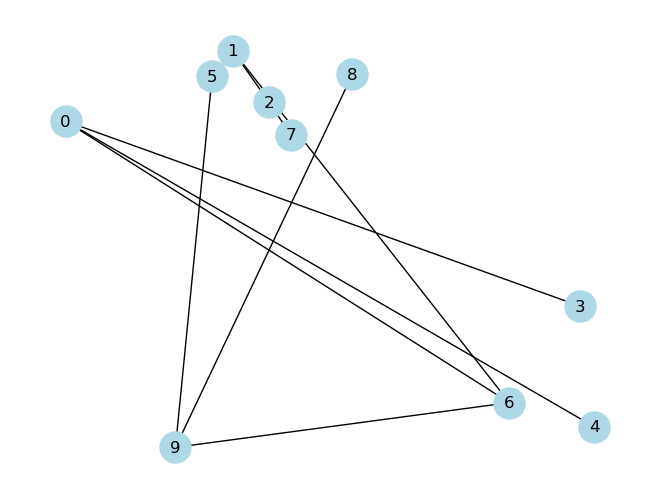

In [15]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [16]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 3), (0, 6), (0, 4), (1, 6), (1, 2), (2, 7), (5, 9), (6, 9), (8, 9)]),
 9)

#### Own Implementation

In [17]:
G=gnp_random_connected_graph(50,100)

In [18]:
def prim(graph: nx.Graph, start=0) -> nx.Graph or None:
    """
    Finds a MST for given graph.
    Returns none if graph is disconnected
    """
    if not nx.is_connected(graph):
        return None
    result_graph=nx.Graph()
    result_graph.add_node(start)
    while set(result_graph.nodes)!=set(graph.nodes):  
        min_edge=min(((u,v,weight['weight']) for u,v,weight in graph.edges(data=True) \
            if (u in result_graph.nodes and v not in result_graph.nodes) or\
                  (u not in result_graph.nodes and v in result_graph.nodes)),\
                    key=lambda x:x[2])
        result_graph.add_edge(min_edge[0],min_edge[1],weight=min_edge[2])
    return result_graph


In [19]:
assert sorted(prim_wrap(G))==sorted(prim(G))


Наша перша імлементація алгоритму Прима знаходить ребро з найменшою вагою в графі, яке є сполученим з тими вершинами, які вже є у каркасі.  
Отож, ми знаходим ребро з мінімальною вагою в списку ребер, у яких одна з вершин ще не міститься у каркасі та має з ним сполучення.

#### Comparison

  0%|          | 0/6 [00:00<?, ?it/s]

OWN IMPLEMENTATION
mean time == 5.3095817565917966e-05 N=5

nx implementation
mean time == 3.552436828613281e-05 N=5
OWN IMPLEMENTATION
mean time == 0.00019943714141845703 N=10

nx implementation
mean time == 5.6695938110351565e-05 N=10
OWN IMPLEMENTATION
mean time == 0.001860666275024414 N=20

nx implementation
mean time == 0.00021226406097412108 N=20


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

OWN IMPLEMENTATION
mean time == 0.025264835357666014 N=50

nx implementation
mean time == 0.0009722709655761719 N=50
OWN IMPLEMENTATION
mean time == 0.191343092918396 N=100

nx implementation
mean time == 0.0037220239639282225 N=100


100%|██████████| 6/6 [00:18<00:00,  3.07s/it]

OWN IMPLEMENTATION
mean time == 1.5546218395233153 N=200

nx implementation
mean time == 0.03475894927978516 N=200


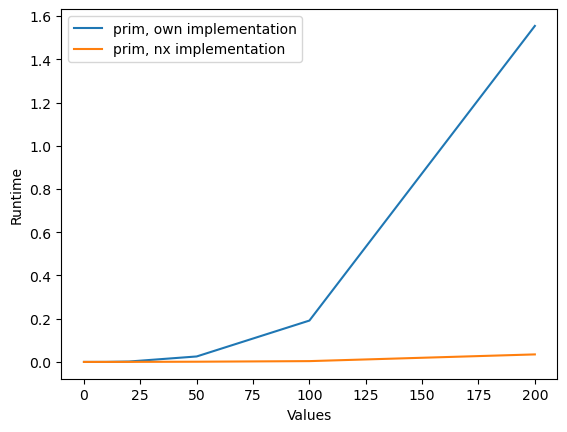

In [20]:
prim_test=Tester(prim,minimum_spanning_tree,"prim")
prim_test.time_test(10,VALS[:-1]) # протестуємо на менших даних;
prim_test.draw_graph()


#### Prim's conclusion
На графіку ми можемо побачити, що наша версія алгоритму Пріма є набагато повільнішою, ніж імлементація NetworkX.  
Усе це через те, що ми кожен раз шукаємо ребро з найменшою вагою по всьому графу (перебігаєм по всім можливим вершинам).  
Можливим покращенням є використання іншої структури даних для зберігання та діставання ребер, наприклад купа.  
Наша імплементація працюватиме за один і той же час в будь-якому графі, немає випадків, де вона проявить себе краще, або гірше, т.я. в будь якому випадку прийдеться проходитись по всім вершинам.  
Усвідомивши те, що можна зробити краще, ми спробували імплементувати алгоритм Прима по іншому

#### Prim 2

In [21]:
def prim_2(graph,start=0):
    if not nx.is_connected(graph):
        return None
    visited=set()
    res_graph=nx.Graph()
    edges=sorted([(u,v,w['weight']) for u,v,w in graph.edges(data=True)],key=lambda x:x[2])
    visited.add(start)
    while len(visited)!=len(graph.nodes):
        for u,v,w in edges:
            if (u in visited and v not in visited) or (v in visited and u not in visited):
                res_graph.add_edge(u,v,weight=w)
                visited.add(v)
                visited.add(u)
    return res_graph

In [22]:
GR=gnp_random_connected_graph(100,100)
sorted(prim_2(GR))==sorted(prim_wrap(GR))

True

  0%|          | 0/7 [00:00<?, ?it/s]

OWN IMPLEMENTATION
mean time == 2.0194053649902344e-05 N=5

nx implementation
mean time == 2.6869773864746094e-05 N=5
OWN IMPLEMENTATION
mean time == 4.8995018005371094e-05 N=10

nx implementation
mean time == 7.040500640869141e-05 N=10
OWN IMPLEMENTATION
mean time == 0.00014994144439697265 N=20

nx implementation
mean time == 0.0002076864242553711 N=20


 71%|███████▏  | 5/7 [00:00<00:00, 30.63it/s]

OWN IMPLEMENTATION
mean time == 0.0008851051330566406 N=50

nx implementation
mean time == 0.0008845806121826171 N=50
OWN IMPLEMENTATION
mean time == 0.0024503231048583984 N=100

nx implementation
mean time == 0.0035634517669677736 N=100
OWN IMPLEMENTATION
mean time == 0.008851051330566406 N=200

nx implementation
mean time == 0.04054639339447021 N=200


100%|██████████| 7/7 [00:05<00:00,  1.31it/s]

OWN IMPLEMENTATION
mean time == 0.0659229040145874 N=500

nx implementation
mean time == 0.2048116683959961 N=500


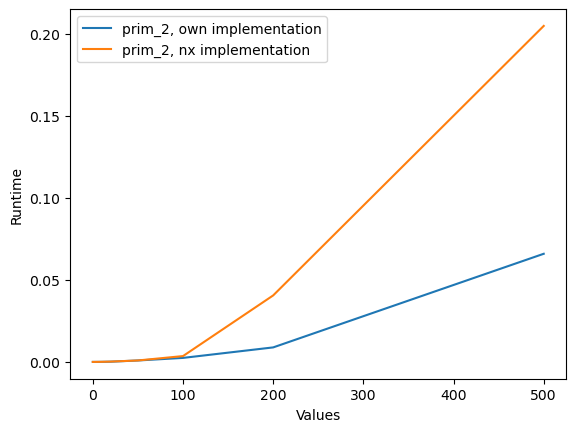

In [23]:
prim2_test=Tester(prim_2,minimum_spanning_tree,"prim")
prim2_test.time_test(10,VALS)
prim2_test.draw_graph()

#### Prim 2 conlucsion
Отож, нам вдалось краще імплементувати алгоритм Прима, т.я. замість того, щоб кожен раз сортувати список вершин - ми перебігаєм по статичному списку вершин. 

### MST conclusion


Порівнявши 2 графіки, можна зрозуміти, що, за правильної імплементації, алгоритм Прима - буде найкращим рішенням.  
Алгоритм Прима при будь-якому наборі даних буде з однаковою швидкістю шукати результат, коли ж робота алгоритма Крускала напряму залежить від вхідних даних.  
Отож, найкращим рішенням для пошуку каркасу з найменшою вагою буде алгоритм Прима.

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [04:52<00:00, 41.81s/it]

[0, 6.091594696044922e-05, 5.238056182861328e-05, 0.00016698837280273437, 0.0008368730545043945, 0.004174494743347168, 0.019677948951721192, 0.311740517616272]
[0, 5, 10, 20, 50, 100, 200, 500]


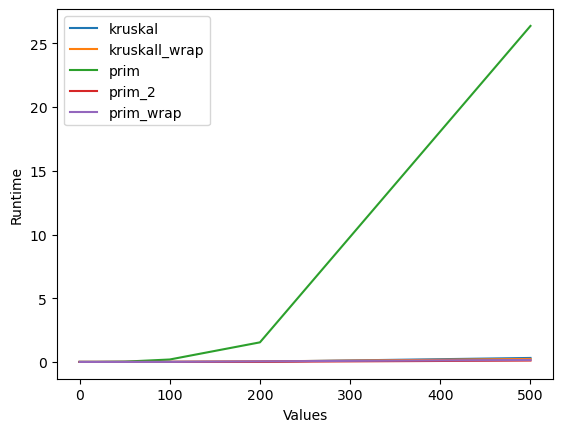

In [24]:
Tester.test_multiple([kruskal,kruskall_wrap,prim,prim_2,prim_wrap],VALS,10)

Можна побачити, що наша перша імплементація Пріма працює задовго.  
Протестуємо без неї.

100%|██████████| 7/7 [00:11<00:00,  1.69s/it]

[0, 3.552436828613281e-05, 5.4836273193359375e-05, 0.00015115737915039062, 0.0008392333984375, 0.004121041297912598, 0.021485233306884767, 0.2878563642501831]
[0, 5, 10, 20, 50, 100, 200, 500]


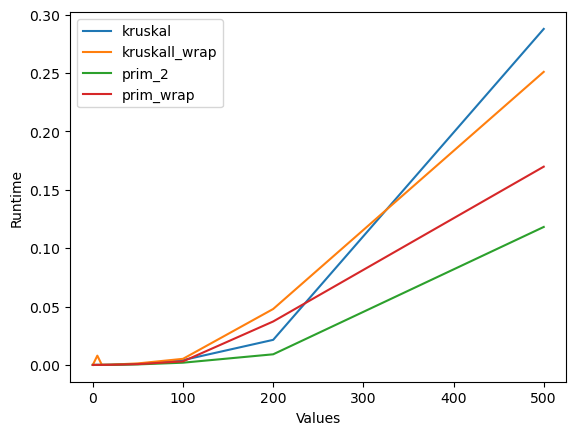

In [25]:
Tester.test_multiple([kruskal,kruskall_wrap,prim_2,prim_wrap],VALS,10)

Тут наглядно показно, що алгоритм Краскала працюватиме швидше за певних умов (ребра каркасу з наймешною вагою йдуть поспіль), але все одно не настільки швидко, як алгоритм Прима.

# For Task 2

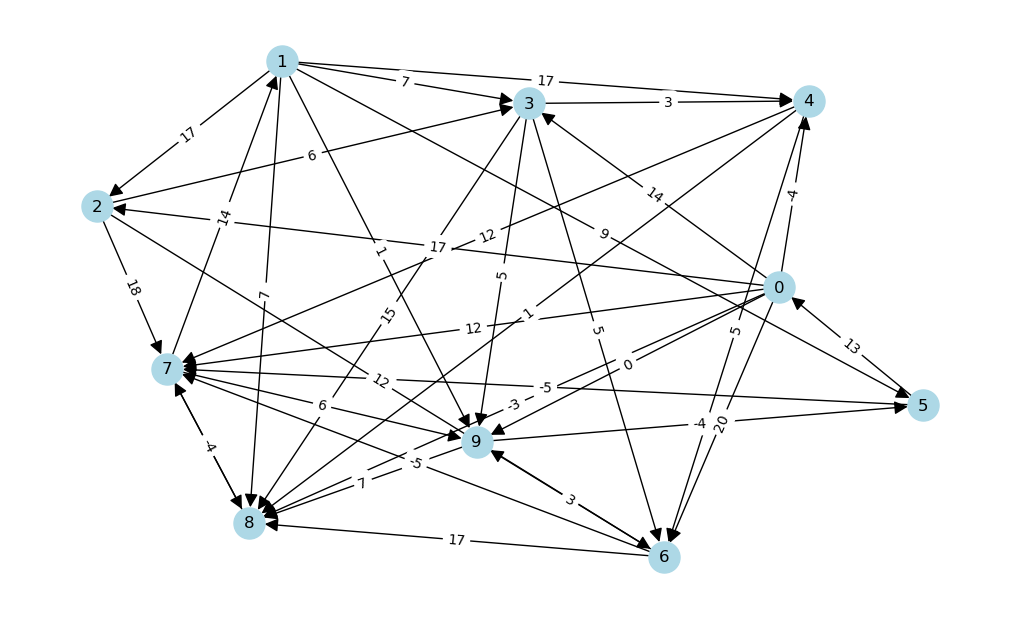

In [26]:
G = gnp_random_connected_graph(10, 0.5, True)
draw(G)

## Bellman-Ford algorithm

#### NetworkX Implementation

In [7]:
from networkx.algorithms import bellman_ford_predecessor_and_distance

In [8]:
def bellman_ford_wrap(Gr,pos=0):
    try:
        return bellman_ford_predecessor_and_distance(Gr,pos)
    except:
        return "Negative cycle detected", None

#### Own Implementation

In [9]:
def bellman_ford(graph: nx.Graph, begin_node:int = 0):
    """
    Finds shortest path with Bellman Ford algorithm
    """
    distance=[float('inf') for _ in range(len(graph.nodes))]
    predecessor=[[] for _ in range(len(graph.nodes))]
    visited=[False for _ in range(len(graph.nodes))]
    distance[begin_node]=0
    for _ in range(len(graph.nodes)-1):
        for u,v,w in graph.edges(data=True):
            if distance[u]+w['weight']<distance[v]:
                distance[v]=distance[u]+w['weight']
                predecessor[v]=[u]
            elif distance[u]+w['weight']==distance[v]:
                if u not in predecessor[v]:
                    predecessor[v].append(u)
    for u,v,w in graph.edges(data=True):
        if distance[u]+w['weight']<distance[v]:
            return f'Negative cycle detected', None
    return {i:val for i,val in enumerate(predecessor)},{i: val for i,val in enumerate(distance)}

Алгоритм Беллмана-Форда дозволяє нам знаходити найкоротші шляхи в графах з від'ємними ребрами без простих циклів.  
Отож, спочатку ми заповнюємо матрицю відстаней та індексів початковими значеннями, після чого перебігаєм по всіх ребрам та дивимось, чи є теперішня відстань гіршою за нову відстань по цьому ребру.  
Урешті-решт, пробігши всі вершини, знову перебігаємо по ним та дивимось, чи змінюється якийсь шлях, аби виявити, чи є від'ємний цикл.

In [10]:
Gr=gnp_random_connected_graph(5,100,True)
print(Gr)
res=bellman_ford_wrap(Gr,0)
print(res)
print(bellman_ford(Gr))
res==bellman_ford(Gr)

DiGraph with 5 nodes and 11 edges
({0: [], 3: [2], 1: [0], 2: [1], 4: [3]}, {0: 0, 3: 10, 1: 12, 2: 11, 4: 10})
({0: [], 1: [0], 2: [1], 3: [2], 4: [3]}, {0: 0, 1: 12, 2: 11, 3: 10, 4: 10})


True

#### Comparison

  0%|          | 0/7 [00:00<?, ?it/s]

OWN IMPLEMENTATION
mean time == 2.460479736328125e-05 N=5

nx implementation
mean time == 3.697872161865234e-05 N=5
OWN IMPLEMENTATION
mean time == 0.00011644363403320312 N=10

nx implementation
mean time == 0.00014460086822509766 N=10
OWN IMPLEMENTATION
mean time == 0.0007845401763916015 N=20

nx implementation
mean time == 0.0006738424301147461 N=20


 57%|█████▋    | 4/7 [00:00<00:00, 16.21it/s]

OWN IMPLEMENTATION
mean time == 0.012165021896362305 N=50

nx implementation
mean time == 0.008916664123535156 N=50
OWN IMPLEMENTATION
mean time == 0.0989640235900879 N=100

nx implementation
mean time == 0.07438058853149414 N=100


 86%|████████▌ | 6/7 [00:16<00:03,  3.42s/it]

OWN IMPLEMENTATION
mean time == 0.808220386505127 N=200

nx implementation
mean time == 0.617406964302063 N=200


100%|██████████| 7/7 [04:26<00:00, 38.11s/it]

OWN IMPLEMENTATION
mean time == 13.269881749153138 N=500

nx implementation
mean time == 11.620005249977112 N=500


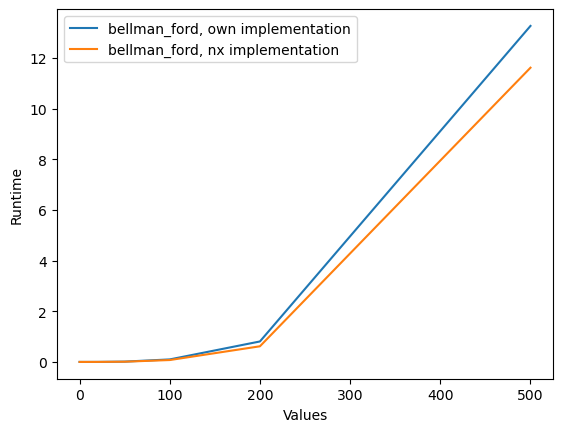

In [24]:
bf_test=Tester(bellman_ford,bellman_ford_wrap, None)
bf_test.time_test(10,VALS)
bf_test.draw_graph()

#### Bellman-Ford conclusion

Ми можемо побачити, що наша імплементація працює не сильно гірше, ніж з модуля NetworkX. Тому, все - реалізовано добре. 

## Floyd-Warshall algorithm

#### NetworkX Implementation

In [11]:
from networkx.algorithms import floyd_warshall_predecessor_and_distance

In [12]:
def warshall_wrap(Gr):
    try:
        return floyd_warshall_predecessor_and_distance(Gr)
    except:
        return "Negative cycle detected"

#### Own Implementation

In [13]:
def floyd_warshall(graph: nx.Graph):
    """
    Finds shortest path between all the pairs of nodes
    """
    distance=[[float('inf') if i!=j else 0 for j in range(len(graph.nodes))]\
             for i in range(len(graph.nodes))]
    pred=[[i if i!=j else 0 for j in range(len(graph.nodes))]\
             for i in range(len(graph.nodes))]
    for u,v,w in graph.edges(data=True):
        distance[u][v]=w['weight']
    for k in range(len(graph.nodes)):
        for i in range(len(graph.nodes)):
            for j in range(len(graph.nodes)):
                if distance[i][j]>distance[i][k]+distance[k][j]:
                    distance[i][j]=distance[i][k]+distance[k][j]
                    pred[i][j]=pred[k][j]
    return {ind:{i: val for i,val in enumerate(row)}for ind,row in enumerate(pred)},\
{ind:{i: val for i,val in enumerate(row)}for ind,row in enumerate(distance)}

Алгоритм Флойда-Воршалла допомагає знайти найкоротші відстані між будь-якими парами вершин в орієнтованому графі.  
Діє за схожим принципом, як і звичайний Воршалл, тільки замість імплікації - ми дивимось, чи змінена відстань буде кращою, ніж поточна.

In [19]:
Gr=gnp_random_connected_graph(10,100,True)

for i,val in enumerate(warshall_wrap(Gr)[1].values()):
    print(dict(val)==floyd_warshall(Gr)[1][i])


True
True
True
True
True
True
True
True
True
True


#### Comparison

  0%|          | 0/7 [00:00<?, ?it/s]

OWN IMPLEMENTATION
mean time == 3.0660629272460936e-05 N=5

nx implementation
mean time == 2.8204917907714843e-05 N=5
OWN IMPLEMENTATION
mean time == 0.00012733936309814454 N=10

nx implementation
mean time == 0.00013129711151123048 N=10
OWN IMPLEMENTATION
mean time == 0.0006835460662841797 N=20

nx implementation
mean time == 0.0008444547653198242 N=20


 57%|█████▋    | 4/7 [00:00<00:00, 16.39it/s]

OWN IMPLEMENTATION
mean time == 0.009782052040100098 N=50

nx implementation
mean time == 0.011134147644042969 N=50
OWN IMPLEMENTATION
mean time == 0.0818742036819458 N=100

nx implementation
mean time == 0.09420843124389648 N=100


 86%|████████▌ | 6/7 [00:16<00:03,  3.46s/it]

OWN IMPLEMENTATION
mean time == 0.6651388168334961 N=200

nx implementation
mean time == 0.7776353359222412 N=200


100%|██████████| 7/7 [04:24<00:00, 37.76s/it]

OWN IMPLEMENTATION
mean time == 11.103899717330933 N=500

nx implementation
mean time == 13.543237805366516 N=500


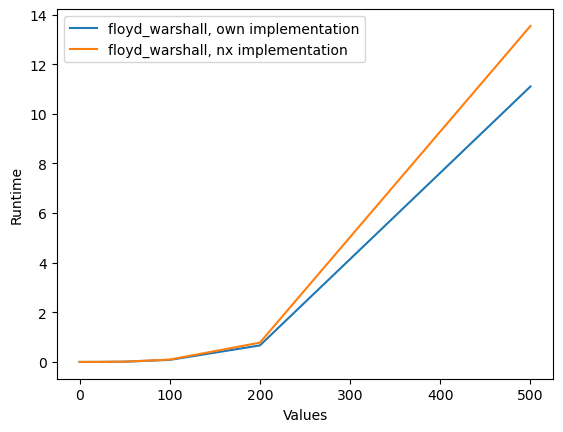

In [87]:
warshall_test=Tester(floyd_warshall,warshall_wrap,None)
warshall_test.time_test(10,VALS,True)
warshall_test.draw_graph()

#### Floyd-Warshall conclusion

Наша імплементація працює досить швидко; краще, ніж з бібліотеки NetworkX.  
Якби замість dict comprehension, повертати початковий 2D масив - час виконання був би сильно кращим.  
*їхня матриця індексів якась дивна; я не дуже зміг розібратись, чому вони саме так робили, т.я. пані Юля пояснювала по іншому*

### Shortest Path conlusion

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [07:43<00:00, 66.17s/it] 

[0, 9.050369262695313e-05, 0.00014989376068115235, 0.00088653564453125, 0.011511397361755372, 0.07879438400268554, 0.3198756217956543, 4.925508713722229]
[0, 5, 10, 20, 50, 100, 200, 500]


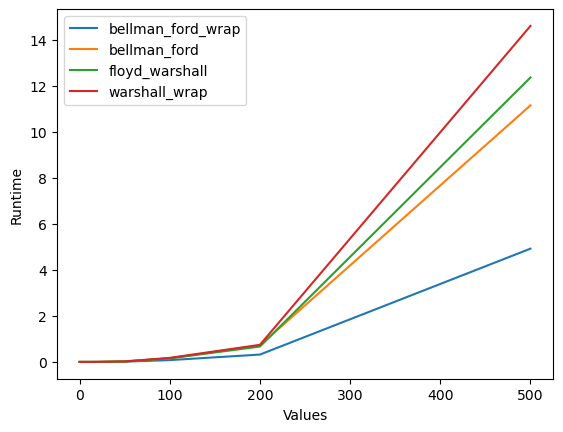

In [20]:
Tester.test_multiple([bellman_ford_wrap,bellman_ford,floyd_warshall,warshall_wrap],VALS,10,True)

### Shortest path conclusion
Отож, ці два алгоритми є найкращими, якщо в нас є інформація про те, що 1) у нас є від'ємні ребра; 2) граф не містить простих від'ємних циклів;  
Якщо нам потрібно знайти відстані між всіма парами вершин - слід використовувати алгоритм Флойда-Воршалла.  
Якщо нам швидко потрібно знайти найкоротші відстані від однієї вершини до інших - варто використовувати алгоритм Беллмана-Форда.  
У цілому, за графіками можна побачити, що ми добре імплементували обидва з алгоритмів, т.я. час виконання є не сильно гіршим, ніж в бібліотеці NetworkX.